In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from utilities import *
from dissipative_utils import *
import numpy.random as random

torch.manual_seed(0)
np.random.seed(0)

font = {'size'   : 28}
matplotlib.rc('font', **font)

This notebook contains code to visualize MNO predictions on the 2D Navier-Stokes equations and compare them to baseline models. While the code is written specifically for visualizing predictions on the 2D Navier-Stokes equations, the notebook can easily be adapted to visualizing predictions on other infinite-dimensional PDE systems.

In particular, we visualize and compare the learned invariant statistics of a U-Net and MNO to the true invariant measure of the system.

# Setup

In [2]:
# Load Data
Re = 40
data = np.load('PATH/TO/DATA')

res = data.shape[-1] # for simplicity, assume x and y resolutions are equal
num_traj = 100 # number of trajectories for sampling
T_in = 100 # > 0 to allow time for generated trajectories to reach attractor
T_out = 500

data = data[:num_traj, T_in:T_out, :, :].reshape(-1, res, res)

truth = torch.tensor(data, dtype=torch.float)

To compare the learned invariant statistics of our models with the true invariant statistics of the system, we need an accurate representation of the models' learned attractors. Thus, we need a long (e.g., 10,000 time-steps) trajectory generated from the model's predictions. Since the model is Markovian, we can give it an initial condition and repeatedly compose it with itself.

Since we are considering ergodic systems, the initial condition does not matter. We take it to be some arbitrary point in the dataset.

In [3]:
# Load predictions
from scipy.io import loadmat

unet_pred = np.load('PATH/TO/PRED.npy') # shape (10000, res, res)
MNO_pred = np.load('PATH/TO/PRED.npy') # shape (10000, res, res)

# Invariant statistics

We compare the learned statistics of U-Net and MNO to the true invariant statistics of the system. For the 2D Navier-Stokes system, some invariant statistics of interest are the distribution of kinetic energy, the vorticity spectrum, and the auto-correlation of the system.

### Vorticity spectrum

In [4]:
def spectrum2(u, s):
    T = u.shape[0]
    u = u.reshape(T, s, s)
    u = torch.fft.fft2(u)

    # 2d wavenumbers following Pytorch fft convention
    k_max = s // 2
    wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1), \
                            torch.arange(start=-k_max, end=0, step=1)), 0).repeat(s, 1)
    k_x = wavenumers.transpose(0, 1)
    k_y = wavenumers
    
    # Sum wavenumbers
    sum_k = torch.abs(k_x) + torch.abs(k_y)
    sum_k = sum_k.numpy()
    
    # Remove symmetric components from wavenumbers
    index = -1.0 * np.ones((s, s))
    index[0:k_max + 1, 0:k_max + 1] = sum_k[0:k_max + 1, 0:k_max + 1]

    spectrum = np.zeros((T, s))
    for j in range(1, s + 1):
        ind = np.where(index == j)
        spectrum[:, j - 1] = np.sqrt( (u[:, ind[0], ind[1]].sum(axis=1)).abs() ** 2)
        
    spectrum = spectrum.mean(axis=0)
    return spectrum

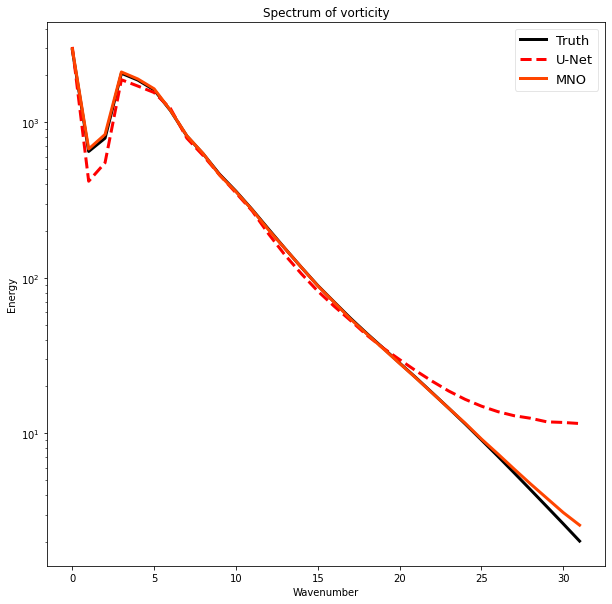

In [5]:
spec_truth = spectrum2(truth, res)[:res//2]
spec_unet = spectrum2(unet_pred, res)[:res//2]
spec_MNO = spectrum2(MNO_pred, res)[:res//2]

fig, ax = plt.subplots(figsize=(10,10))

linewidth = 3
ax.set_yscale('log')
ax.plot(spec_truth, 'k', label='Truth', linewidth=linewidth)
ax.plot(spec_unet, 'r--', label='U-Net', linewidth=linewidth)
ax.plot(spec_MNO, 'orangered', label='MNO', linewidth=linewidth)

plt.legend(prop={'size': 20})
plt.title('Spectrum of vorticity')
plt.xlabel('Wavenumber')
plt.ylabel('Energy')

leg = plt.legend(loc='best', prop={'size':13})
leg.get_frame().set_alpha(0.5)
plt.show()

### Histograms

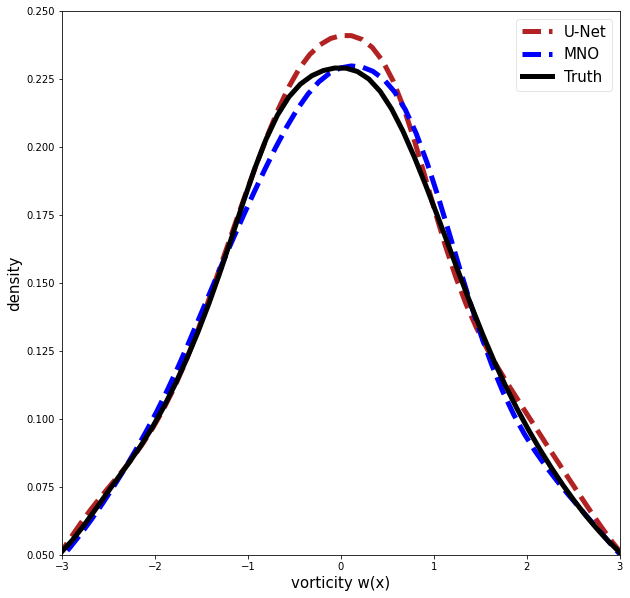

In [6]:
truth_numpy = truth.numpy()
unet_pred_numpy = unet_pred.numpy()
MNO_pred_numpy = MNO_pred.numpy()

fig, ax = plt.subplots(figsize=(10,10))
linewidth = 5

sns.distplot(ax=ax, a=unet_pred_numpy.reshape(-1)[random.permutation(len(unet_pred_numpy.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=50, label='U-Net', \
             kde_kws=dict(linewidth=linewidth,linestyle='--',color='firebrick'))

sns.distplot(ax=ax, a=MNO_pred_numpy.reshape(-1)[random.permutation(len(MNO_pred_numpy.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=50, label='MNO', \
             kde_kws=dict(linewidth=linewidth,linestyle='--',color='blue'))

sns.distplot(ax=ax, a=truth_numpy.reshape(-1)[random.permutation(len(truth_numpy.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=50, label='Truth', \
             kde_kws=dict(linewidth=linewidth,color='k'))

ax.set_xlim(-3,3)
ax.set_ylim(0.05,0.25)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.xlabel('vorticity w(x)', fontsize=15)
plt.ylabel('density', fontsize=15)

leg = plt.legend(loc='upper right', prop={'size': 15})
leg.get_frame().set_alpha(0.5)
plt.show()

### Distribution of dissipation

In [7]:
def dissipation(w, Re):
    T = w.shape[0]
    s = w.shape[1]
    w = w.reshape(T, s*s)
    return torch.mean(w**2, dim=1) / Re

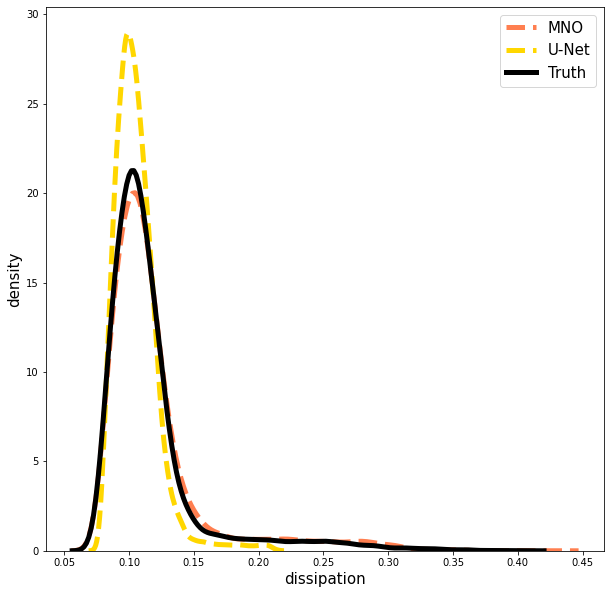

In [8]:
E_truth = dissipation(truth, Re)
E_unet_pred = dissipation(unet_pred, Re)
E_MNO_pred = dissipation(MNO_pred, Re)

fig, ax = plt.subplots(figsize=(10,10))
linewidth = 5

sns.distplot(ax=ax, a=E_MNO_pred.reshape(-1)[random.permutation(len(E_MNO_pred.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=500, label='MNO', \
             kde_kws=dict(linewidth=linewidth,linestyle='--',color='coral'))
sns.distplot(ax=ax, a=E_unet_pred.reshape(-1)[random.permutation(len(E_unet_pred.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=500, label='U-Net', \
             kde_kws=dict(linewidth=linewidth,linestyle='--',color='gold'))
sns.distplot(ax=ax, a=E_truth.reshape(-1)[random.permutation(len(E_truth.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=500, label='Truth', \
             kde_kws=dict(linewidth=linewidth,color='k'))

plt.legend(prop={'size': 15})
plt.xlabel('dissipation', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.show()

### Kinetic energy distribution

In [9]:
def TKE(u):
    T = u.shape[0]
    s = u.shape[1]
    u = u.reshape(T, s*s*2)
    umean = torch.mean(u, dim=0)
    return torch.mean((u-umean)**2, dim=1)

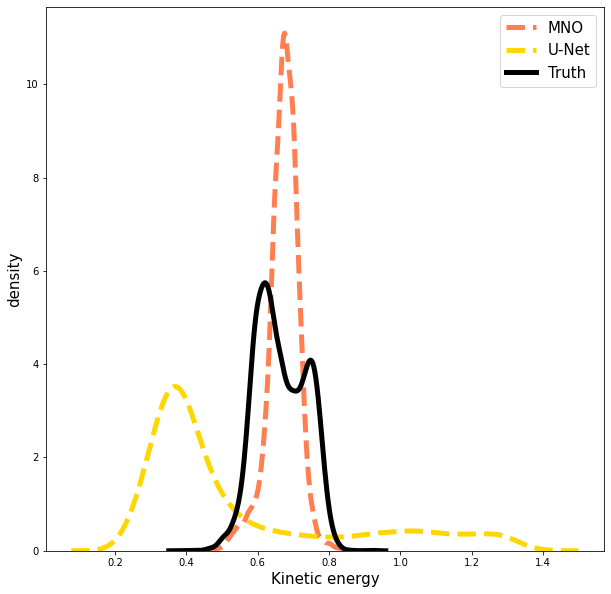

In [10]:
index = [0,1]
truth_u = w_to_u(truth)[..., index]
unet_u = w_to_u(unet_pred)[..., index]
MNO_u = w_to_u(MNO_pred)[..., index]

KE_truth = TKE(truth_u)
KE_unet = TKE(unet_u)
KE_MNO = TKE(MNO_u)

fig, ax = plt.subplots(figsize=(10,10))
linewidth = 5

sns.distplot(ax=ax, a=KE_MNO.reshape(-1)[random.permutation(len(KE_MNO.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=500, label='MNO', \
             kde_kws=dict(linewidth=linewidth,linestyle='--',color='coral'))
sns.distplot(ax=ax, a=KE_unet.reshape(-1)[random.permutation(len(KE_unet.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=500, label='U-Net', \
             kde_kws=dict(linewidth=linewidth,linestyle='--',color='gold'))
sns.distplot(ax=ax, a=KE_truth.reshape(-1)[random.permutation(len(KE_truth.reshape(-1)))[:10000]], \
             kde=True, hist=False, bins=500, label='Truth', \
             kde_kws=dict(linewidth=linewidth,color='k'))

plt.legend(prop={'size': 15})
plt.xlabel('Kinetic energy', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.show()

### PCA autocorrelation

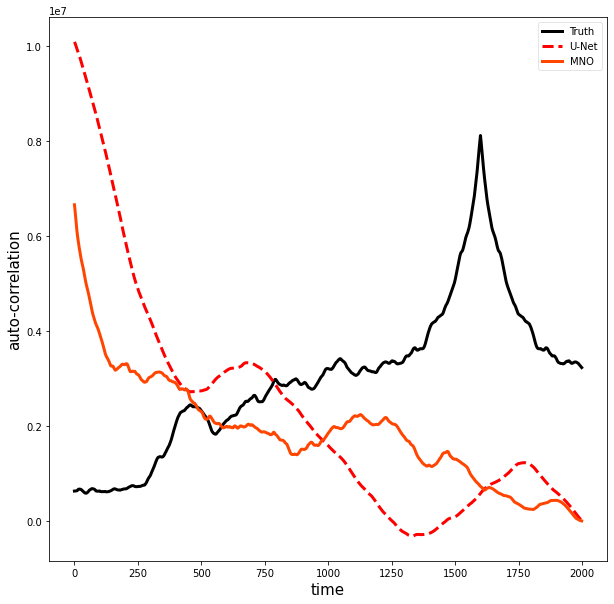

In [11]:
PCA_dim = 50

x_pca = PCA(truth.reshape(-1, res*res), PCA_dim, subtract_mean=False)

index = 0
T = 2000
pca_truth = x_pca.encode(truth.reshape(-1, res*res))[:T, index]
pca_unet_pred = x_pca.encode(unet_pred.reshape(-1, res*res))[:T, index]
pca_MNO_pred = x_pca.encode(MNO_pred.reshape(-1, res*res))[:T, index]

T_show = 2000
pca_truth = np.correlate(pca_truth, pca_truth, mode='full')[400-1:400-1+T_show]
pca_unet_pred = np.correlate(pca_unet_pred, pca_unet_pred, mode='full')[T-1:T-1+T_show]
pca_MNO_pred = np.correlate(pca_MNO_pred, pca_MNO_pred, mode='full')[T-1:T-1+T_show]

fig, ax = plt.subplots(figsize=(10,10))

num = 2000 -  np.array(range(T_show))

linewidth = 3
ax.plot(pca_truth, 'k', label='Truth', linewidth=linewidth)
ax.plot(pca_unet_pred, 'r--', label='U-Net', linewidth=linewidth)
ax.plot(pca_MNO_pred, 'orangered', label='MNO', linewidth=linewidth)

plt.legend(prop={'size': 15})
plt.xlabel('time', fontsize=15)
plt.ylabel('auto-correlation', fontsize=15)

leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.show()